### Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn import set_config

set_config(display="diagram") #setting this will display your pipelines as seen above

In [36]:
cali = pd.read_csv('data/housing.csv')

In [37]:
cali.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


In [38]:
cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [39]:
cali['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [ ]:
# get the data, dropna, one-hot for ocean_proximity
# drop islands because they are too few
# shuffle and split it into 3 sets
# get baselines
# see what the most strongly correlated features are

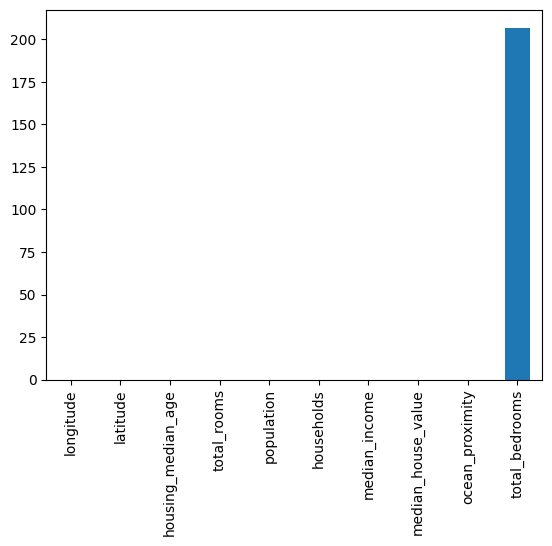

In [40]:
# Create a barplot using `matplotlib` with the $x$-axis representing the columns and the $y$-axis representing the count of missing values
cali.isnull().sum().sort_values().plot(kind = 'bar')
plt.show();

# Drop entries missing bedroom data
cali_cleen_1 = cali.dropna()
#cali_cleen_1.info()

# Drop the 5 entries where the ocean proximity is "ISLAND"
cali_cleen_2 = cali_cleen_1.drop(cali_cleen_1.index[cali_cleen_1['ocean_proximity']=='ISLAND'],axis=0)
#cali_cleen_2.info()

cali_cleen_2["ocean_proximity"] = cali_cleen_2["ocean_proximity"].str.replace("INLAND","0")
cali_cleen_2["ocean_proximity"] = cali_cleen_2["ocean_proximity"].str.replace("<1H OCEAN","1")
cali_cleen_2["ocean_proximity"] = cali_cleen_2["ocean_proximity"].str.replace("NEAR BAY","2")
cali_cleen_2["ocean_proximity"] = cali_cleen_2["ocean_proximity"].str.replace("NEAR OCEAN","3")

cali_cleen_2["ocean_proximity"] = cali_cleen_2["ocean_proximity"].astype(int)

## Split into training, validation and test sets

In [75]:
# Shuffle and split into training, validation, and test sets, 20433 is the total num of rows
cali_train, cali_valid, cali_test = np.split( cali_cleen_2.sample(frac = 1), [11_977, 16_023] )

# Drop target feature from valid and test sets
cali_train_X = cali_train.drop('median_house_value', axis = 1)
cali_train_y = cali_train['median_house_value']

# Drop target feature from valid and test sets
cali_test_X = cali_test.drop('median_house_value', axis = 1)
cali_test_y = cali_test['median_house_value']

cali_train.head()

c:\Users\sspillane\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8361,-118.33,33.96,42,1686,361.0,737,319,2.3000,189200,1
7144,-118.13,34.02,41,734,190.0,565,191,2.2813,192000,1
3271,-122.91,39.07,21,2202,484.0,1000,381,2.4423,102300,0
14075,-117.12,32.76,28,1605,501.0,936,460,2.5991,147500,3
15851,-122.43,37.74,52,3328,653.0,1260,614,4.7437,331000,2


In [45]:
# to id and view the most closely correlated features. from 8.7 #3
highest_corr = cali_train_corr.corr()[['median_house_value']].nlargest(columns = 'median_house_value', n = 10).index[:]
print(highest_corr)
highest_corr_values = cali_train_corr.corr()[['median_house_value']].nlargest(columns = 'median_house_value', n = 10)
print(highest_corr_values)
# sns.heatmap(cali_train_corr.corr(), annot=True)

Index(['median_house_value', 'median_income', 'ocean_proximity', 'total_rooms',
       'housing_median_age', 'households', 'total_bedrooms', 'population',
       'longitude', 'latitude'],
      dtype='object')
                    median_house_value
median_house_value            1.000000
median_income                 0.690814
ocean_proximity               0.387938
total_rooms                   0.132593
housing_median_age            0.096483
households                    0.064466
total_bedrooms                0.050225
population                   -0.025307
longitude                    -0.049662
latitude                     -0.139059


In [10]:
# ordinal_transformer = make_column_transformer( (OrdinalEncoder(categories = [['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN']]), ['ocean_proximity']),
#                                                 remainder='passthrough')

In [43]:
# See 8.7 #6 for adding more columns
pipe_1_col = Pipeline([
                #('col_transformer', ordinal_transformer),
                ('linreg', LinearRegression())
            ])
pipe_1_col.fit(cali_train[['median_income']], cali_train['median_house_value'])

Pipeline(steps=[('linreg', LinearRegression())])

In [51]:
train_mses = []
test_mses = []
min_mses = []

num = 11

for i in range(1, num):
    #ordinal_transformer = make_column_transformer( (OrdinalEncoder(categories = [['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN']]), ['ocean_proximity']),
    #                                            remainder='passthrough')
    
    pipeline = Pipeline([
                        #('transformer', ordinal_transformer),
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['median_income']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['median_income']])
    test_preds = pipeline.predict(cali_test[['median_income']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

The Complexity that minimized Test Error was: 7
The Minimum Test Error was: 6639121317.810169


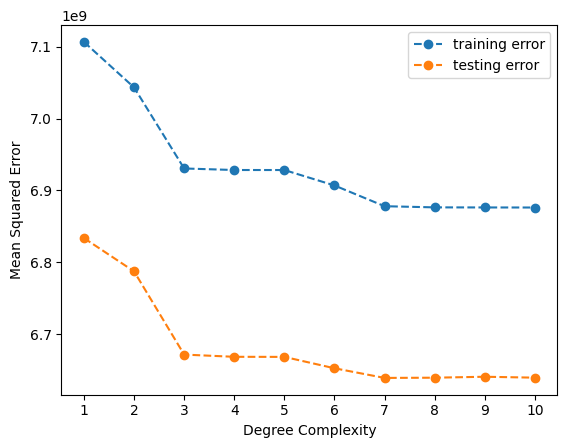

In [52]:
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

### Now do it with different Individual columns

#### 2. Train on ocean_proximity

In [48]:

train_mses = []
test_mses = []

num = 11

for i in range(1, num):
    #ordinal_transformer = make_column_transformer( (OrdinalEncoder(categories = [['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN']]), ['ocean_proximity']),
    #                                            remainder='passthrough')
    
    pipeline = Pipeline([
                        #('transformer', ordinal_transformer),
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['ocean_proximity']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['ocean_proximity']])
    test_preds = pipeline.predict(cali_test[['ocean_proximity']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

The Complexity that minimized Test Error was: 6
The Minimum Test Error was: 10244982142.598406


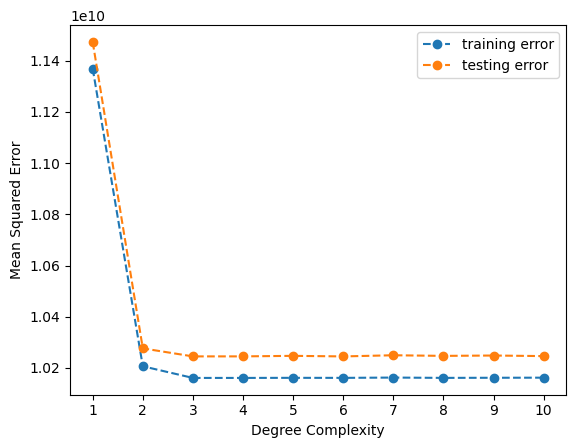

In [50]:
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

#### 3. Train on total_rooms

The Complexity that minimized Test Error was: 4
The Minimum Test Error was: 12861220695.870811


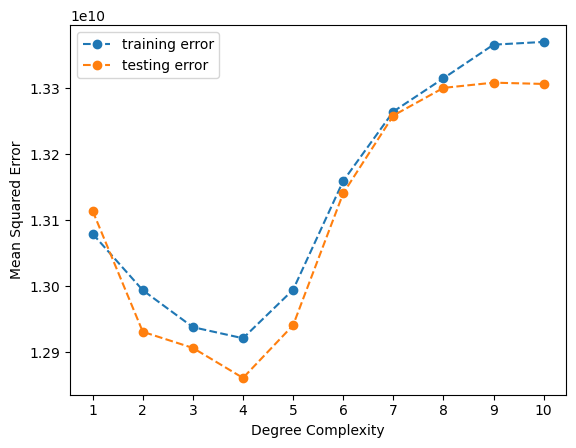

In [53]:
train_mses = []
test_mses = []

num = 11

for i in range(1, num):
    #ordinal_transformer = make_column_transformer( (OrdinalEncoder(categories = [['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN']]), ['ocean_proximity']),
    #                                            remainder='passthrough')
    
    pipeline = Pipeline([
                        #('transformer', ordinal_transformer),
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['total_rooms']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['total_rooms']])
    test_preds = pipeline.predict(cali_test[['total_rooms']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

#### 4. Train on housing_median_age

The Complexity that minimized Test Error was: 9
The Minimum Test Error was: 12870664613.500624


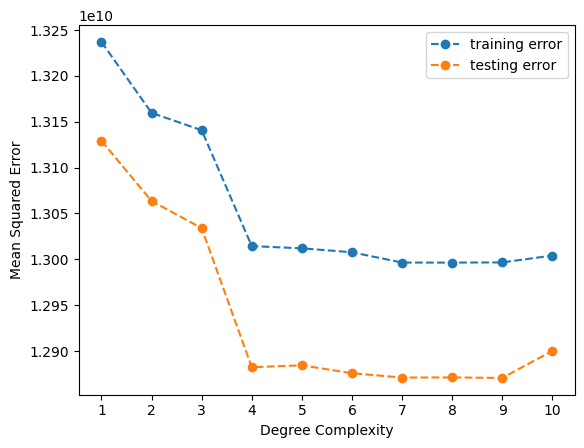

In [56]:
train_mses = []
test_mses = []

num = 11

for i in range(1, num):
    
    pipeline = Pipeline([
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['housing_median_age']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['housing_median_age']])
    test_preds = pipeline.predict(cali_test[['housing_median_age']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

#### 4. Train on combinations of:
'median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age'

The Complexity that minimized Test Error was: 7
The Minimum Test Error was: 5201337026.739764


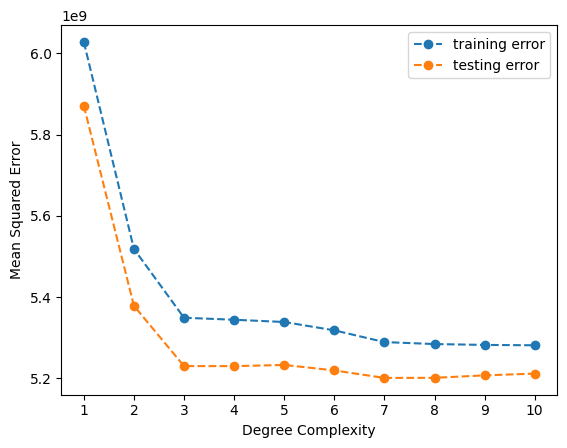

In [57]:
# 'median_income', 'ocean_proximity'
train_mses = []
test_mses = []

num = 11

for i in range(1, num):
    
    pipeline = Pipeline([
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['median_income', 'ocean_proximity',]], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['median_income', 'ocean_proximity']])
    test_preds = pipeline.predict(cali_test[['median_income', 'ocean_proximity']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

The Complexity that minimized Test Error was: 3
The Minimum Test Error was: 6658223781.374777


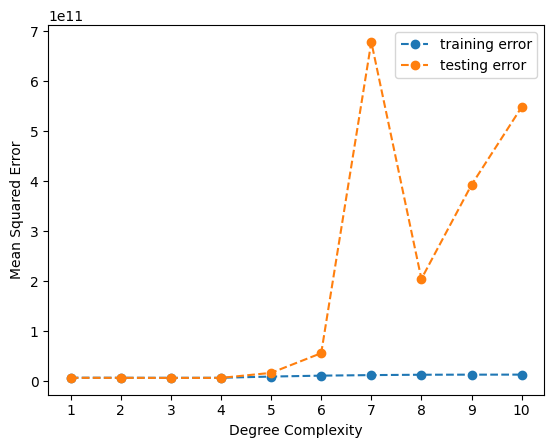

In [59]:
# 'median_income', 'total_rooms'

train_mses = []
test_mses = []

num = 11

for i in range(1, num):
    
    pipeline = Pipeline([
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['median_income', 'total_rooms',]], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['median_income', 'total_rooms']])
    test_preds = pipeline.predict(cali_test[['median_income', 'total_rooms']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

The Complexity that minimized Test Error was: 3
The Minimum Test Error was: 9782861610.908386


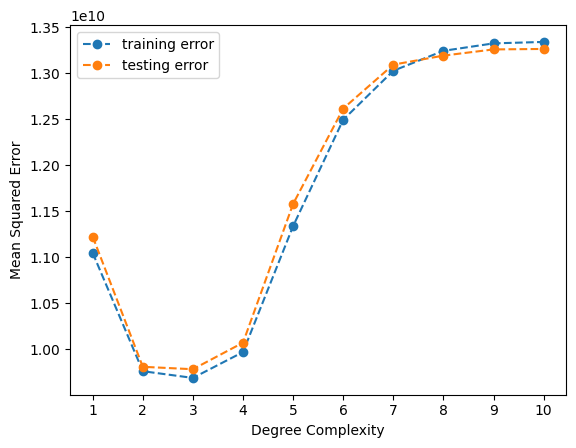

In [60]:
# 'ocean_proximity', 'total_rooms'
train_mses = []
test_mses = []

num = 11

for i in range(1, num):
    
    pipeline = Pipeline([
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['ocean_proximity', 'total_rooms',]], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['ocean_proximity', 'total_rooms']])
    test_preds = pipeline.predict(cali_test[['ocean_proximity', 'total_rooms']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

The Complexity that minimized Test Error was: 3
The Minimum Test Error was: 5215430034.692474


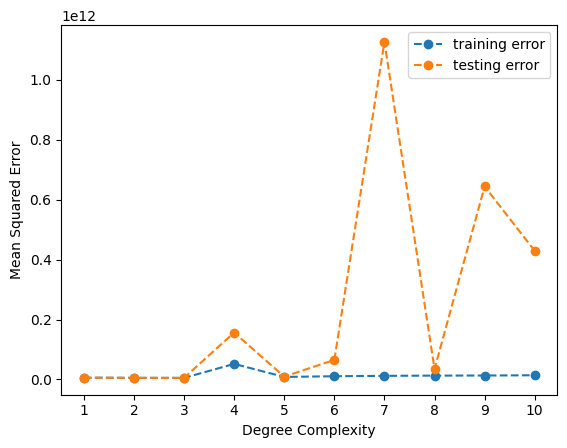

In [63]:
# 'median_income', 'ocean_proximity', 'total_rooms'
train_mses = []
test_mses = []

num = 11

for i in range(1, num):
    
    pipeline = Pipeline([
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['median_income', 'ocean_proximity', 'total_rooms']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['median_income', 'ocean_proximity', 'total_rooms']])
    test_preds = pipeline.predict(cali_test[['median_income', 'ocean_proximity', 'total_rooms']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

The Complexity that minimized Test Error was: 3
The Minimum Test Error was: 4666651514.925683


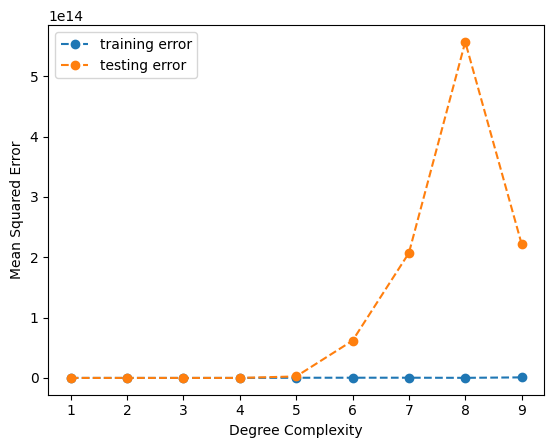

In [70]:
# 'median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age'
train_mses = []
test_mses = []

num = 10

for i in range(1, num):
    
    pipeline = Pipeline([
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age']])
    test_preds = pipeline.predict(cali_test[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

The Complexity that minimized Test Error was: 3
The Minimum Test Error was: 4549794774.708631


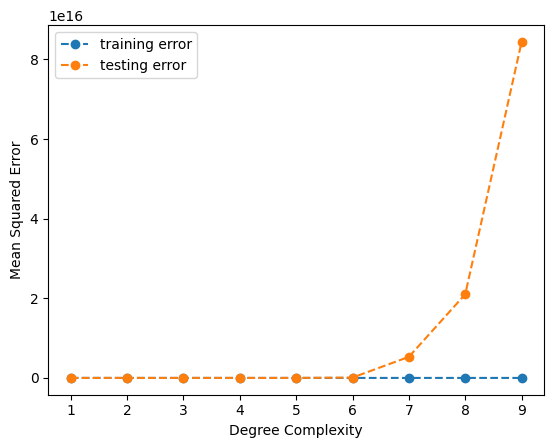

In [72]:
# 'median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age', 'households'
train_mses = []
test_mses = []
r2_score = []

num = 10

for i in range(1, num):
    
    pipeline = Pipeline([
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age', 'households']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age', 'households']])
    test_preds = pipeline.predict(cali_test[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age', 'households']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(cali_test['median_house_value'], test_preds))
    r2_score.append(pipeline.score(cali_train[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age', 'households']], cali_train['median_house_value']))

print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Minimum Test Error was: {min(test_mses)}')
plt.plot(range(1, num), train_mses, '--o', label = 'training error')
plt.plot(range(1, num), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, num), range(1, num))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

In [73]:
print(r2_score)

[0.5828047628017122, 0.6267606514649354, 0.6594829286324007, -1.955399305585055, 0.1062457816800545, -4.84474223644995, -2.980304044768095, -3.18897876119859, -0.8987164910976666]


In [87]:
# Calculate the permutation importance
r_vals = permutation_importance(pipeline, cali_test[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age', 'households']], cali_test['median_house_value'])
importances = pd.DataFrame(data=r_vals.importances_mean, columns=['Importance']).sort_values(by='Importance', ascending=False)
print(importances)

# 0=median income, 1=ocean_proximity, 2=total_rooms, 3=housing_median_age, 4=households

     Importance
4  1.806657e+13
2  5.274671e+12
3  1.960477e+08
0  4.630981e+06
1  1.523787e+06
